In [ ]:
#Installing Scanpy along with other Single Cell dependencies
%pip install numpy anndata scanpy[skmisc] igraph leidenalg umap-learn muon plotnine harmonypy pydeseq2 pymemesuite pyjaspar pyupset gprofiler-official psutil pynvml imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.7/293.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 27.6 MB/s eta 0:00:00
   ━━━━━

In [ ]:
#Libraries for downloading/manipulating data
import os, gc
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt

# Core scverse libraries
import anndata as ad
import scanpy as sc

import seaborn as sns
from scipy.stats import median_abs_deviation

#plotting
from plotnine import (
    ggplot,
    aes,
    scale_x_log10,
    scale_y_log10,
    geom_point,
    geom_violin,
    geom_boxplot,
    geom_jitter,
    theme_matplotlib,
    theme_set,
)
from gprofiler import GProfiler
from pyjaspar import jaspardb
import Bio
from typing import List

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

from scipy.sparse import diags

# Data retrieval
import pooch
from muon import atac as ac

#Libraries for XGBoost implementation
import xgboost as xgb
import time
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.preprocessing import LabelEncoder

#RAM-CPU profiling
import psutil
import threading
import pynvml

#Undersampling the dataset
from imblearn.under_sampling import RandomUnderSampler

<h2>Part 0: Downloading the dataset and RAM/CPU measuring function</h2>



In [ ]:
def download_dataset():
  """
  Download and load the single-cell RNA sequencing dataset as an AnnData object.

    Here, a dataset is downloaded from a certain URL, consequetively the dataset is loaded into an AnnData object.
    Input: !wget -c downloadLink -O sameNameAsFile.h5ad
    Returns: adata (AnnData file)
  """
  #!wget -c https://datasets.cellxgene.cziscience.com/f4b594d9-1c81-420d-9cac-d9cb7041c921.h5ad  -O human_gland_50k.h5ad
  #adata = ad.read_h5ad("human_gland_50k.h5ad")
  !wget -c https://datasets.cellxgene.cziscience.com/29d50da1-430a-482c-ac9a-7077c727aa34.h5ad  -O human_tissue_60k.h5ad
  adata = ad.read_h5ad("human_tissue_60k.h5ad")

  return adata
adata = download_dataset()

--2025-03-19 09:37:28--  https://datasets.cellxgene.cziscience.com/29d50da1-430a-482c-ac9a-7077c727aa34.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 13.32.87.99, 13.32.87.125, 13.32.87.40, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|13.32.87.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
#RAM-GPU-CPU profiling
pynvml.nvmlInit()

def GPU_measures():
  """
  Measures the current usage of GPU
  Input: None
  Output: GPU memory usage in Mb
  """
  handle = pynvml.nvmlDeviceGetHandleByIndex(0) #Selects any GPU available
  gpu_usage = pynvml.nvmlDeviceGetUtilizationRates(handle) #Gets the use percentage of the GPU
  gpu_perc = gpu_usage.gpu

  return gpu_perc

training = True #Boolean required for threading the RAM/CPU process
ram_usage, cpu_usage, gpu_usage = [],[],[]

def RAM_CPU_GPU_measures():
  """
  Measures the current use of RAM and CPU every second and stores them in their respective arrays
  Input: None
T  Output: RAM, CPU and GPU usage arrays
  """
  while training:
    time.sleep(1)
    ram_usage.append(psutil.virtual_memory().percent)
    cpu_usage.append(psutil.cpu_percent())
    gpu_usage.append(GPU_measures())


<h2>Part 1: Data preprocessing</h2>

In [ ]:
def preprocessing(adata,min_genes,min_cells,max_perc,min_perc,cut_2k):
  """
  Performs a rutinary (low-expressed genes, outlier removal, normalization and log transformation)
  pre-processing assay to the input data

  Input: AnnData file, minimum of expressing genes, minimum of expressing cells, maximum and minimum quantiles, and
  boolean if only the most variable genes are wanted
  Output: AnnData file with preprocessed data
  """
  prev_dims = adata.shape
  sc.pp.filter_cells(adata, min_genes=min_genes) #Eliminate cells that do not express at least min_genes
  sc.pp.filter_genes(adata, min_cells=min_cells) #Delete genes that are not expressed in at least min_cells

  #Required for quantile calculations
  adata.var["mt"] = adata.var_names.str.startswith("MT-") #Creates an additional column with the variable "MT" (to see if the gene is mitochondrial or not upfront)
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], log1p=False, inplace=True) #Calculates metrics

  #Quantile calculations
  up_lim = np.quantile(adata.obs.n_genes_by_counts.values, max_perc)
  low_lim = np.quantile(adata.obs.n_genes_by_counts.values,min_perc)
  adata = adata[(adata.obs.n_genes_by_counts < up_lim) & (adata.obs.n_genes_by_counts > low_lim)] #Deletes genes outside of the quantile range

  #Normalizing and log transforming data
  sc.pp.normalize_total(adata, target_sum = 1e4) #1e4: Normalization standard
  sc.pp.log1p(adata)

  #Taking the n_top_genes most variable genes only
  if cut_2k == True:
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
    adata = adata[:,adata.var["highly_variable"]]

  new_dims = adata.shape
  print("Initial dims: {} \nDims after preprocessing: {}".format(prev_dims,new_dims))
  return adata

st = time.time()
adata = preprocessing(adata, min_genes = 200, min_cells = 3, max_perc = 0.95, min_perc = 0.05,cut_2k = False)
print("Preprocessing time: {:.2f} s".format(time.time()-st))

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.


Initial dims: (61525, 36406) 
Dims after preprocessing: (55369, 32746)
Preprocessing time: 19.50 s


<h1>Part 1.1: Reducing the dataset using PCs</h1>

<h2>Part 2: Gradient boosting using XGBoost</h2>

In [ ]:
def dataset_reduction(adata,method):
  """
  Reduces dataset size based on various methods (PCA-based, random undersampling) if wanted.
  Also produces training and testing splits on a dataset contained in the input AnnData file.

  Input: AnnData file (previously preprocessed) and method {"pca","undersampling", "raw"}
  Output: Original dataset along with reduced training and testing splits from the AnnData file
  """
  #Encoding labels (giving them a number between 0 and n_types-1)
  enc = LabelEncoder()
  enc.fit(adata.obs["cell_type"])
  y = enc.transform(adata.obs["cell_type"])

  if method == None: #Raw dataset
    X = adata.X

  elif method == "pca": #Dataset reduced by PCAs
    try:
      X = adata.obsm["X_pca"]
    except:
      sc.pp.pca(adata)
      print("Dataset had no X_pca. Function will run again")
      #dataset_reduction(adata,method)

  elif method == "undersampling": #Dataset reduced by Random Undersampling
    X = adata.X
    rus = RandomUnderSampler(sampling_strategy = "all", random_state=42)
    X, y = rus.fit_resample(X,y)

  #Splitting our data into training and testing (80:20 split)
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

  return X, X_train, X_test, y_train, y_test


In [ ]:
#XGBoost implementation with time, memory and CPU metrics
method = "undersampling"
X, X_train, X_test, y_train, y_test = dataset_reduction(adata,method = method)
st = time.time()

clas = xgb.XGBClassifier(objective = "multi:softmax", random_state = 42, eval_metric = "mlogloss", device = "cuda") #cuda enables GPU usage if available
threading.Thread(target = RAM_CPU_GPU_measures,daemon=True).start() #RAM/CPU measuring in real time
clas.fit(X_train,y_train)

training = False
print("Runtime: {:.3f} s".format(time.time()-st))

Runtime: 76.740 s


<h2>Part 3: Metrics and performance</h2>

In [ ]:
#Only for undersampling assay
X = adata.X
enc = LabelEncoder()
enc.fit(adata.obs["cell_type"])
y = enc.transform(adata.obs["cell_type"])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

y_pred = clas.predict(X_test)

#Finding the confusion matrix, accuracy score and F1-score
import sklearn.metrics as skm
#Calculating our metrics
conf = skm.confusion_matrix(y_test,y_pred) #Confusion matrix
acc = skm.accuracy_score(y_test,y_pred) #Accuracy score
f1 = skm.f1_score(y_test,y_pred,average = "weighted") #F1-score

#print("Confusion matrix:")
#print(conf)
print("accuracy: {:.3f}".format(acc))
print("f1-score: {:.3f}".format(f1))

accuracy: 0.914
f1-score: 0.918


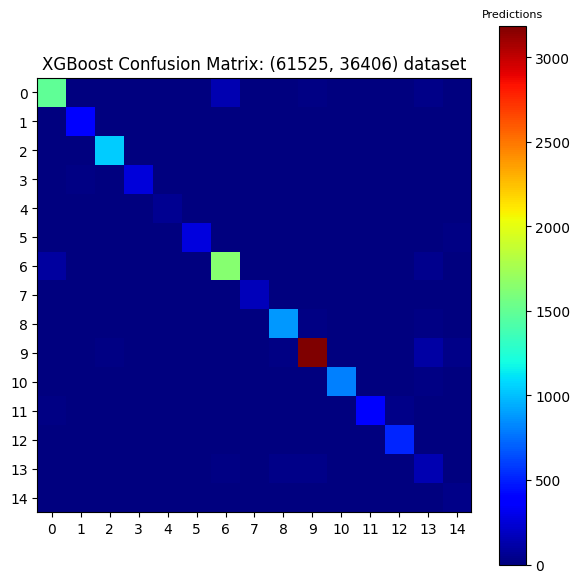

In [ ]:
n_classes = len(set(y_train))


plt.figure(figsize=(7,7))
plt.title("XGBoost Confusion Matrix: {} dataset".format(X.shape))
plt.imshow(conf,cmap="jet")
plt.xticks(np.arange(n_classes))
plt.yticks(np.arange(n_classes))
clb = plt.colorbar()
clb.ax.set_title('Predictions',fontsize=8)

np.savetxt("cm_XGB_{}x{}_{}.csv".format(X.shape[0],X.shape[1],method), conf, delimiter=",")


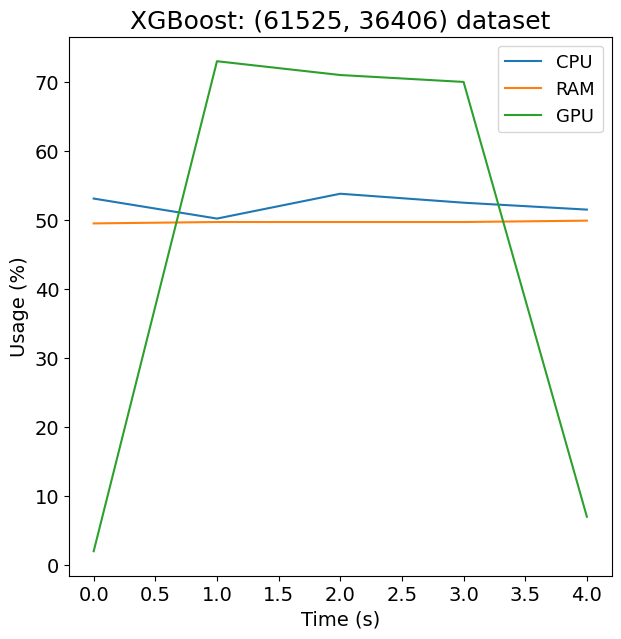

In [ ]:
plt.figure(figsize=(7,7))
plt.title("XGBoost: {} dataset".format(X.shape),fontsize=18)
plt.plot(cpu_usage,label="CPU")
plt.plot(ram_usage,label="RAM")
plt.plot(gpu_usage,label="GPU")
plt.xlabel("Time (s)",fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel("Usage (%)",fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 13)
#plt.savefig("comp_metrics_{}x{}.png".format(X.shape[0],X.shape[1]),dpi = 300)

In [ ]:
#Storing all usage metrics in a .csv dataset
metrics = {"cpu":cpu_usage, "ram": ram_usage, "gpu": gpu_usage, "acc": acc, "f1": f1, "time (s)": len(gpu_usage)}
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("comp_metrics_XGB_{}x{}_{}.csv".format(X.shape[0],X.shape[1],method))